In [ ]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline

In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer

In [2]:
dev = qml.device("default.qubit")

In [3]:
def layer(layer_weights):
    for wire in range(4):
        qml.Rot(*layer_weights[wire], wires=wire)

    for wires in ([0, 1], [1, 2], [2, 3], [3, 0]):
        qml.CNOT(wires)

We also need a way to encode data inputs $x$ into the circuit, so that
the measured output depends on the inputs. In this first example, the
inputs are bitstrings, which we encode into the state of the qubits. The
quantum state $\psi$ after state preparation is a computational basis
state that has 1s where $x$ has 1s, for example

$$x = 0101 \rightarrow |\psi \rangle = |0101 \rangle .$$

The `~pennylane.BasisState`{.interpreted-text role="class"} function
provided by PennyLane is made to do just this. It expects `x` to be a
list of zeros and ones, i.e. `[0,1,0,1]`.


In [4]:
def state_preparation(x):
    qml.BasisState(x, wires=[0, 1, 2, 3])

Now we define the variational quantum circuit as this state preparation
routine, followed by a repetition of the layer structure.


In [5]:
@qml.qnode(dev)
def circuit(weights, x):
    state_preparation(x)

    for layer_weights in weights:
        layer(layer_weights)

    return qml.expval(qml.PauliZ(0))

If we want to add a "classical" bias parameter, the variational quantum
classifier also needs some post-processing. We define the full model as
a sum of the output of the quantum circuit, plus the trainable bias.


In [6]:
def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

# Cost

In supervised learning, the cost function is usually the sum of a loss
function and a regularizer. We restrict ourselves to the standard square
loss that measures the distance between target labels and model
predictions.


In [7]:
def square_loss(labels, predictions):
    # We use a call to qml.math.stack to allow subtracting the arrays directly
    return np.mean((labels - qml.math.stack(predictions)) ** 2)

To monitor how many inputs the current classifier predicted correctly,
we also define the accuracy, or the proportion of predictions that agree
with a set of target labels.


In [8]:
def accuracy(labels, predictions):
    acc = sum(abs(l - p) < 1e-5 for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc

For learning tasks, the cost depends on the data - here the features and
labels considered in the iteration of the optimization routine.


In [9]:
def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

# Optimization

Let's now load and preprocess some data.



In [10]:
data = np.loadtxt("variational_classifier/data/parity_train.txt", dtype=int)
X = np.array(data[:, :-1])
Y = np.array(data[:, -1])
Y = Y * 2 - 1  # shift label from {0, 1} to {-1, 1}

for x,y in zip(X, Y):
    print(f"x = {x}, y = {y}")

FileNotFoundError: variational_classifier/data/parity_train.txt not found.

We initialize the variables randomly (but fix a seed for
reproducibility). Remember that one of the variables is used as a bias,
while the rest is fed into the gates of the variational circuit.


In [ ]:
np.random.seed(0)
num_qubits = 4
num_layers = 2
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

print("Weights:", weights_init)
print("Bias: ", bias_init)

Next we create an optimizer instance and choose a batch size...


In [ ]:
opt = NesterovMomentumOptimizer(0.5)
batch_size = 5

...and run the optimizer to train our model. We track the accuracy - the
share of correctly classified data samples. For this we compute the
outputs of the variational classifier and turn them into predictions in
$\{-1,1\}$ by taking the sign of the output.


In [ ]:
weights = weights_init
bias = bias_init
for it in range(100):

    # Update the weights by one optimizer step, using only a limited batch of data
    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, bias = opt.step(cost, weights, bias, X=X_batch, Y=Y_batch)

    # Compute accuracy
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X]

    current_cost = cost(weights, bias, X, Y)
    acc = accuracy(Y, predictions)

    print(f"Iter: {it+1:4d} | Cost: {current_cost:0.7f} | Accuracy: {acc:0.7f}")

As we can see, the variational classifier learned to classify all bit
strings from the training set correctly.

But unlike optimization, in machine learning the goal is to generalize
from limited data to *unseen* examples. Even if the variational quantum
circuit was perfectly optimized with respect to the cost, it might not
generalize, a phenomenon known as *overfitting*. The art of (quantum)
machine learning is to create models and learning procedures that tend
to find \"good\" minima, or those that lead to models which generalize
well.

With this in mind, let\'s look at a test set of examples we have not
used during training:


In [ ]:
data = np.loadtxt("variational_classifier/data/parity_test.txt", dtype=int)
X_test = np.array(data[:, :-1])
Y_test = np.array(data[:, -1])
Y_test = Y_test * 2 - 1  # shift label from {0, 1} to {-1, 1}
    
predictions_test = [np.sign(variational_classifier(weights, bias, x)) for x in X_test]

for x,y,p in zip(X_test, Y_test, predictions_test):
    print(f"x = {x}, y = {y}, pred={p}")
    
acc_test = accuracy(Y_test, predictions_test)
print("Accuracy on unseen data:", acc_test)


# 2. Iris classification



In [11]:
def get_angles(x):
    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(np.linalg.norm(x[2:]) / np.linalg.norm(x))

    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])


def state_preparation(a):
    qml.RY(a[0], wires=0)

    qml.CNOT(wires=[0, 1])
    qml.RY(a[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[2], wires=1)

    qml.PauliX(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[3], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[4], wires=1)
    qml.PauliX(wires=0)

Let's test if this routine actually works.


In [12]:
x = np.array([0.53896774, 0.79503606, 0.27826503, 0.0], requires_grad=False)
ang = get_angles(x)


@qml.qnode(dev)
def test(angles):
    state_preparation(angles)

    return qml.state()


state = test(ang)

print("x               : ", np.round(x, 6))
print("angles          : ", np.round(ang, 6))
print("amplitude vector: ", np.round(np.real(state), 6))

x               :  [0.538968 0.795036 0.278265 0.      ]
angles          :  [ 0.563975 -0.        0.       -0.975046  0.975046]
amplitude vector:  [ 0.538968  0.795036  0.278265 -0.      ]


The method computed the correct angles to prepare the desired state!

> ::: note
> ::: title
> Note
> :::
>
> The `default.qubit` simulator provides a shortcut to
> `state_preparation` with the command `qml.StatePrep(x, wires=[0, 1])`.
> On state simulators, this just replaces the quantum state with our
> (normalized) input. On hardware, the operation implements more
> sophisticated versions of the routine used above.
> :::


Since we are working with only 2 qubits now, we need to update the
`layer` function. In addition, we redefine the `cost` function to pass
the full batch of data to the state preparation of the circuit
simultaneously, a technique similar to NumPy broadcasting.


In [13]:
def layer(layer_weights):
    for wire in range(2):
        qml.Rot(*layer_weights[wire], wires=wire)
    qml.CNOT(wires=[0, 1])


def cost(weights, bias, X, Y):
    # Transpose the batch of input data in order to make the indexing
    # in state_preparation work
    predictions = variational_classifier(weights, bias, X.T)
    return square_loss(Y, predictions)

# Data

We load the Iris data set. There is a bit of preprocessing to do in
order to encode the inputs into the amplitudes of a quantum state. We
will augment the data points by two so-called \"latent dimensions\",
making the size of the padded data point match the size of the state
vector in the quantum device. We then need to normalize the data points,
and finally, we translate the inputs x to rotation angles using the
`get_angles` function we defined above.

Data preprocessing should always be done with the problem in mind; for
example, if we do not add any latent dimensions, normalization erases
any information on the length of the vectors and classes separated by
this feature will not be distinguishable.

::: note
::: title
Note
:::

The Iris dataset can be downloaded
`<a href="https://raw.githubusercontent.com/XanaduAI/qml/master/_static/demonstration_assets/variational_classifier/data/iris_classes1and2_scaled.txt"
download=parity.txt target="_blank">here</a>`{.interpreted-text
role="html"} and should be placed in the subfolder
`variational_classifer/data`.
:::


In [14]:
data = np.loadtxt("iris_classes1and2_scaled.txt")
X = data[:, 0:2]
print(f"First X sample (original)  : {X[0]}")

# pad the vectors to size 2^2=4 with constant values
padding = np.ones((len(X), 2)) * 0.1
X_pad = np.c_[X, padding]
print(f"First X sample (padded)    : {X_pad[0]}")

# normalize each input
normalization = np.sqrt(np.sum(X_pad**2, -1))
X_norm = (X_pad.T / normalization).T
print(f"First X sample (normalized): {X_norm[0]}")

# the angles for state preparation are the features
features = np.array([get_angles(x) for x in X_norm], requires_grad=False)
print(f"First features sample      : {features[0]}")

Y = data[:, -1]

First X sample (original)  : [0.4  0.75]
First X sample (padded)    : [0.4  0.75 0.1  0.1 ]
First X sample (normalized): [0.46420708 0.87038828 0.11605177 0.11605177]
First features sample      : [ 0.32973573 -0.78539816  0.78539816 -1.080839    1.080839  ]


These angles are our new features, which is why we have renamed X to
"features" above. Let's plot the stages of preprocessing and play around
with the dimensions (dim1, dim2). Some of them still separate the
classes well, while others are less informative.


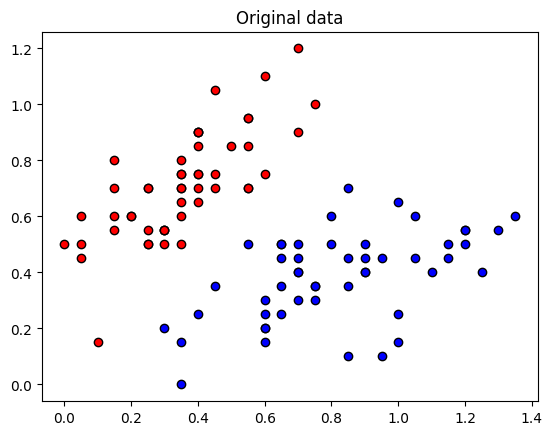

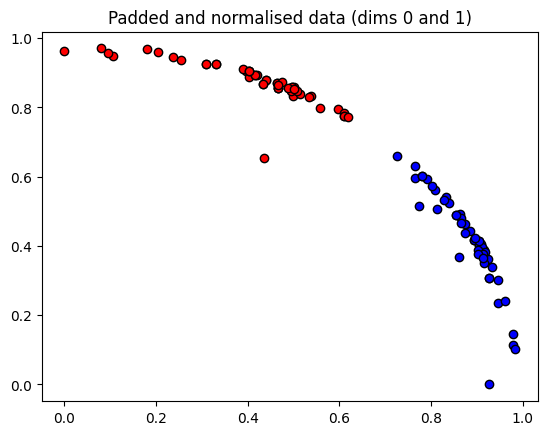

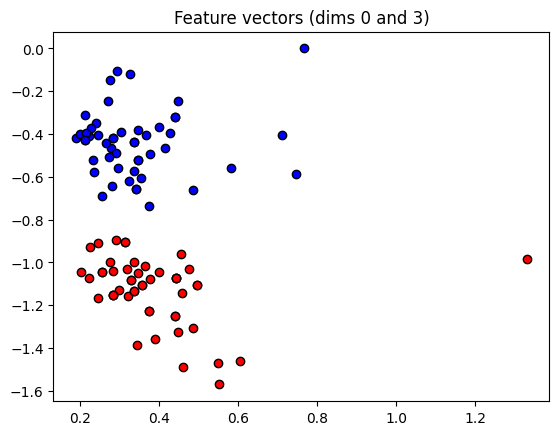

In [15]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(X[:, 0][Y == 1], X[:, 1][Y == 1], c="b", marker="o", ec="k")
plt.scatter(X[:, 0][Y == -1], X[:, 1][Y == -1], c="r", marker="o", ec="k")
plt.title("Original data")
plt.show()

plt.figure()
dim1 = 0
dim2 = 1
plt.scatter(X_norm[:, dim1][Y == 1], X_norm[:, dim2][Y == 1], c="b", marker="o", ec="k")
plt.scatter(X_norm[:, dim1][Y == -1], X_norm[:, dim2][Y == -1], c="r", marker="o", ec="k")
plt.title(f"Padded and normalised data (dims {dim1} and {dim2})")
plt.show()

plt.figure()
dim1 = 0
dim2 = 3
plt.scatter(features[:, dim1][Y == 1], features[:, dim2][Y == 1], c="b", marker="o", ec="k")
plt.scatter(features[:, dim1][Y == -1], features[:, dim2][Y == -1], c="r", marker="o", ec="k")
plt.title(f"Feature vectors (dims {dim1} and {dim2})")
plt.show()

This time we want to generalize from the data samples. This means that
we want to train our model on one set of data and test its performance
on a second set of data that has not been used in training. To monitor
the generalization performance, the data is split into training and
validation set.


In [16]:
np.random.seed(0)
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]

# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]

# Optimization

First we initialize the variables.


In [22]:
num_qubits = 2
num_layers = 6

weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
print("Weights shape:", weights_init.shape)
bias_init = np.array(0.0, requires_grad=False)

Weights shape: (6, 2, 3)


Again we minimize the cost, using the imported optimizer.


In [ ]:
opt = NesterovMomentumOptimizer(0.01)
batch_size = 5

# train the variational classifier
weights = weights_init
bias = bias_init
for it in range(60):
    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch, Y_train_batch)

    # Compute predictions on train and validation set
    predictions_train = np.sign(variational_classifier(weights, bias, feats_train.T))
    predictions_val = np.sign(variational_classifier(weights, bias, feats_val.T))

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)

    if (it + 1) % 2 == 0:
        _cost = cost(weights, bias, features, Y)
        print(
            f"Iter: {it + 1:5d} | Cost: {_cost:0.7f} | "
            f"Acc train: {acc_train:0.7f} | Acc validation: {acc_val:0.7f}\n"
            f"weights: {weights} | bias: {bias}\n"     
        )

TypeError: Rot.__init__() missing 2 required positional arguments: 'theta' and 'omega'

We can plot the continuous output of the variational classifier for the
first two dimensions of the Iris data set.


In [ ]:
plt.figure()
cm = plt.cm.RdBu

# make data for decision regions
xx, yy = np.meshgrid(np.linspace(0.0, 1.5, 30), np.linspace(0.0, 1.5, 30))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

# preprocess grid points like data inputs above
padding = 0.1 * np.ones((len(X_grid), 2))
X_grid = np.c_[X_grid, padding]  # pad each input
normalization = np.sqrt(np.sum(X_grid**2, -1))
X_grid = (X_grid.T / normalization).T  # normalize each input
features_grid = np.array([get_angles(x) for x in X_grid])  # angles are new features
predictions_grid = variational_classifier(weights, bias, features_grid.T)
Z = np.reshape(predictions_grid, xx.shape)

# plot decision regions
levels = np.arange(-1, 1.1, 0.1)
cnt = plt.contourf(xx, yy, Z, levels=levels, cmap=cm, alpha=0.8, extend="both")
plt.contour(xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])

# plot data
for color, label in zip(["b", "r"], [1, -1]):
    plot_x = X_train[:, 0][Y_train == label]
    plot_y = X_train[:, 1][Y_train == label]
    plt.scatter(plot_x, plot_y, c=color, marker="o", ec="k", label=f"class {label} train")
    plot_x = (X_val[:, 0][Y_val == label],)
    plot_y = (X_val[:, 1][Y_val == label],)
    plt.scatter(plot_x, plot_y, c=color, marker="^", ec="k", label=f"class {label} validation")

plt.legend()
plt.show()

We find that the variational classifier learnt a separating line between
the datapoints of the two different classes, which allows it to classify
even the unseen validation data with perfect accuracy.

# About the author
